In [1]:
### Loading Credentials from local file; 
### this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 4:  Example Case - History of Physiology</font>

# Defining the Physiology Graph

Search for "hysiolog" as substring for Physiology to retrieve every possible string containing.


In [2]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (t:TopicTerm)
WHERE t.Name CONTAINS "hysiolog"
RETURN DISTINCT(t.Name) as term
"""

with driver.session() as session:
    all_physiology_terms = session.run(query).data()
    
all_physiology_terms

[{'term': 'Arbeitsphysiologie'},
 {'term': 'Neurophysiologie'},
 {'term': 'Pathophysiologie'},
 {'term': 'Pflanzenphysiologie'},
 {'term': 'Physiologie'},
 {'term': 'Sinnesphysiologie'},
 {'term': 'Tierphysiologie'},
 {'term': 'Physiologische Chemie'},
 {'term': 'Physiologische Psychologie'},
 {'term': 'Sprachphysiologie'},
 {'term': 'Sportphysiologie'},
 {'term': 'Leistungsphysiologie'},
 {'term': 'Physiologische Psychiatrie'},
 {'term': 'Elektrophysiologie'},
 {'term': 'Altersphysiologie'},
 {'term': 'Bewegungsphysiologie'},
 {'term': 'Entwicklungsphysiologie'},
 {'term': 'Ernährungsphysiologie'},
 {'term': 'Ertragsphysiologie'},
 {'term': 'Histophysiologie'},
 {'term': 'Höhenphysiologie'},
 {'term': 'Nacherntephysiologie'},
 {'term': 'Physiologische Optik'},
 {'term': 'Physiologische Uhr'},
 {'term': 'Psychophysiologische Diagnostik'},
 {'term': 'Stoffwechselphysiologie'},
 {'term': 'Vegetative Physiologie'},
 {'term': 'Vergleichende Neurophysiologie'},
 {'term': 'Vergleichende Ph

Let's see whether every topic term also has people connected to them. 

In [36]:
from helper_functions.helper_fun import to_nx_graph

query = """
MATCH (t:TopicTerm)-[r]-(n:PerName)
WHERE t.Name CONTAINS "hysiolog"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

Check which topic terms aren't present in query result:

In [37]:
import numpy as np

relevant_topics = []
for node in list(G.nodes):
    if G.nodes[node]["type"] == "TopicTerm":
        relevant_topics.append((G.nodes[node]["label"]))

np.setdiff1d([d["term"] for d in all_physiology_terms], relevant_topics)

array(['Altersphysiologie', 'Bewegungsphysiologie',
       'Elektrophysiologische Untersuchung', 'Ertragsphysiologie',
       'Experimentelle Physiologie', 'Histophysiologie',
       'Ignaz-L.-Lieben-Preis für Physik, Chemie und Physiologie',
       'Muskelphysiologie', 'Physiologische Optik', 'Physiologische Uhr',
       'Psychophysiologische Diagnostik', 'Reizphysiologie',
       'Sprachphysiologie', 'Tauchphysiologie', 'Umweltphysiologie',
       'Vergleichende Neurophysiologie', 'Vergleichende Physiologie',
       'Zellphysiologie'], dtype='<U57')

@todo add colors to network below by node type

In [38]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

nt = Network('750px', '100%', notebook=True, directed = True)
nt.from_nx(G)
nt.set_edge_smooth("dynamic")
#nt.show('./html_networks/physiological_net.html')

## Retrieving the Network

In [6]:
%%time

from helper_functions.helper_fun import to_nx_graph

query = """
MATCH (t:TopicTerm)--(n)
WHERE t.Name CONTAINS "hysiolog" AND (n:PerName)
WITH DISTINCT [x in collect(t)+collect(n)|id(x)] as collectedIds 
MATCH (n)-[rel1:RelationToPerName|SocialRelation|RelationToResource|RelationToGeoName|RelationCorpName|RelationToUniTitle*0..1]-(n2)
WHERE id(n) in collectedIds 
RETURN n, n2, rel1
"""


driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

CPU times: user 57.7 s, sys: 2.93 s, total: 1min
Wall time: 2min 59s


In [7]:
import pickle

filename = 'physiology_graph'
outfile = open(filename,'wb')

pickle.dump(G,outfile)
outfile.close()

In [3]:
import pickle

with open('physiology_graph', 'rb') as f:
    G = pickle.load(f)

## Descriptive Metrics

In [4]:
print("Number of Nodes: ", G.number_of_nodes())
print("Number of Edges: ", G.number_of_edges())

Number of Nodes:  47732
Number of Edges:  56119


In [5]:
types_list = list(set([y["type"] for x,y in G.nodes(data=True)]))
person_nodes = [x for x,y in G.nodes(data=True) if y['type']=="PerName"]
resources_and_works_nodes = [x for x,y in G.nodes(data=True) if y['type'] in ["Resource", "UniTitle"]]
corps_nodes = [x for x,y in G.nodes(data=True) if y['type']=="CorpName"]
geo_nodes = [x for x,y in G.nodes(data=True) if y['type']=="GeoName"]
topicterm_nodes = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

print("Node types in Graph:", types_list)
print("Number of Persons in Graph: ", len(person_nodes))
print("Number of Resources and Works in Graph: ", len(resources_and_works_nodes))
print("Number of Corporations in Graph: ", len(corps_nodes))
print("Number of GeoNames in Graph:", len(geo_nodes))
print("")
print("## Topic Terms in Graph: ## ")
for node in topicterm_nodes:
    print(G.nodes(data=True)[node]["label"])

Node types in Graph: ['TopicTerm', 'CorpName', 'MeetName', 'GeoName', 'PerName', 'Resource', 'UniTitle']
Number of Persons in Graph:  11727
Number of Resources and Works in Graph:  34304
Number of Corporations in Graph:  1094
Number of GeoNames in Graph: 560

## Topic Terms in Graph: ## 
Arbeitsphysiologie
Neurophysiologie
Pathophysiologie
Pflanzenphysiologie
Physiologie
Sinnesphysiologie
Tierphysiologie
Physiologische Chemie
Physiologische Psychologie
Sportphysiologie
Leistungsphysiologie
Physiologische Psychiatrie
Elektrophysiologie
Entwicklungsphysiologie
Ernährungsphysiologie
Höhenphysiologie
Nacherntephysiologie
Stoffwechselphysiologie
Vegetative Physiologie
Verhaltensphysiologie
Physiologe
Physiologin
Physiologische Akustik
Pflanzenphysiologe
Pflanzenphysiologin
Bernoulli-Balken
Bernoulli-Balken
Bathybius haeckelii
Bathybius haeckelii


Let's add a color attribute to the nodes based on the node types. This way visualizations of the network will be more informative to us. 

In [6]:
import networkx as nx
type_list = list([y["type"] for x,y in G.nodes(data=True)])

color_map = {"GeoName": "green",
             "CorpName": "red",
             "TopicTerm": "yellow",
             "PerName": "blue",  
             "Resource": "purple", 
             "MeetName": "orange", 
             "UniTitle": "pink"}

# We generate a dictionary again to map the respective type to the correct color
color_dict = dict(zip(list(G.nodes), [color_map.get(item, item) for item in type_list]))

# And finally we add the color information as a new attribute to the graph object
nx.set_node_attributes(G, color_dict, "color")

### Check Density and Connectedness of Network

Since our network is pretty large, it is a bit complicated to investigate the network visually from within this notebook. This is why we start investigating the network with some further descriptive assessments. 


Let's start with the *density* of the network. The *Network density* measures how many relationships between nodes exist in relation to how many relations are possible. Graph density for an undirected Graph is calculated as follows:

\begin{align}
x & = \frac{m}{n(n-1)/2}
\end{align}

$n$ is the number of nodes and $m$ is the number of relationships in the graph. By calculating $n(n-1)/2$ we get the number of possible relationships in the graph. Basically we divide the number of edges by the number of possible edges and so we get the *density*. 
When every node is connected to every other node in the network, the density is 1. On the other hand, when there are no relationships between any nodes, the density is 0. 

We calculate the density to see how connected our graph is. 

The formula for a directed graph is slightly different from the formula presented above. Click [here](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html?highlight=density) for more details.

In [7]:
import networkx as nx

nx.density(G)

4.926400935949988e-05

As we can see, the density of our network is very low. This means that the nodes in our network are not very connected to each other. This could mean, that the graph consists of many isolated nodes or many little *components*. 

Let's at first check whether this assumption is true. To do so, we can assess the *connectivity* of the graph. A graph is considered to be connected, as long as there is a possibility to traverse from every node in the graph to any other node. Or in other words: A graph is disconnected, when it consists of isolated subgraphs, also called *components*.

We can use the `is_connected()` method of the networkx library to do the connectivity check. [Here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_connected.html#networkx.algorithms.components.is_connected) you can find the documentation of the function. 



In [8]:
nx.is_connected(G)

False

Apparently the physiology graph is not fully connected and therefore there are isolated components in the graph. So let's try to understand, what these components are.

**Components** 

Whenever you work with a network taken from the real world, it's quite common that the network is not fully connected. 
As we just found out, the physiology network also seems to consist of isolated "islands of nodes". Let's find out how many components our network has and how big they are. 

We will use some of the components algorithm the `networkx` library provides. [Here](https://networkx.org/documentation/stable/reference/algorithms/component.html) you can find an overview of all components related algorithms available. 

We can use the method `number_connected_components()` to recieve the number of components in our graph.

In [9]:
nx.number_connected_components(G)

687

There are nearly 700 components present in the graph. Let's investigate them further.

By using the method `connected_components()` we can get a list containing the nodes present in each of the 685 components.  

In [10]:
# retrieve a list of all components and the associated nodes
components = nx.connected_components(G)

# now we create a list containg the information about each component size (number of nodes)
component_size_list = [len(component) for component in components]

# let's print some summary details
print("number of unique component sizes (number of nodes):", len(set(component_size_list)))
print("maximum component length:", max(set(component_size_list)))
print("minimum component length:", min(set(component_size_list)))

number of unique component sizes (number of nodes): 24
maximum component length: 45921
minimum component length: 1


Alright, as we can see from the output above, there are 24 distinct component sizes. This means that each of the 685 components takes one of 24 different sizes. The sizes of the components have a range from 1 node (a single node without any relationships) to 48175 nodes. 

Let's check the distribution of the components sizes next.

<AxesSubplot:>

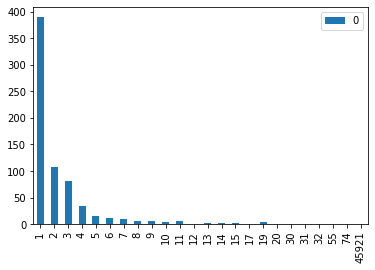

In [11]:
import numpy as np
import pandas as pd

values, counts = np.unique(component_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

More than 50% of the components in our graph are isolated nodes. There are quite some components with just a few nodes in them. But there is this one huge cluster with 48175 nodes. 

Let's create a subgraph of the largest component. As we want to explore the network of physiologists it might be most interesting to investigate the largest component and not the smaller ones.

We can use the method `subgraph()` to extract the graph of the largest component. We just need to pass in a list of nodes we want to include in the new subgraph. Click [here](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html) for the documentation of the method.

In [12]:
# at first we extract the the largest component

components = nx.connected_components(G)
largest_component = max([component for component in components], key = len)
print(len(largest_component))

largest_component_graph = G.subgraph(largest_component)

45921


Now we have our subgraph and we know that is is a connected graph now. Let's check if this assumption is true:

In [13]:
nx.is_connected(largest_component_graph)

True

Perfect, so let's go on investigating this subgraph now.

# Investigating the Persons

## Centrality Investigation

At first we are going to investigate the centrality of the physiology network. By assessing the centrality we actually calculate the importance or the role of the nodes in a graph. Centrality metrics are used to identify the most important nodes in a network. Also, these metrics can be helpful to understand group dynamics like credibility, accessibility or flow of information. 

In this section about investigating the centrality of the physiology network, we won't apply path-based algorithms like betweenness centrality or information centrality, because path based calculations are very costly computational wise. A small overview of centrality metrics you can choose from provides the table below.

| Centrality name | Characteristics of a central node|
|:----------------|:---------------|
|Degree Centrality|Connected to many other nodes|
|Eigenvector Centrality|Connected to many other nodes and/or to other high-degree nodes|
|PageRank|Connected to many other nodes and connected to other high-degree nodes|
|Shortest-path Betweenness Centrality|Lies on many shortest topological paths linking other node pairs|
|Shortest-path Closeness|  Low average shortest path length to other nodes in the network|

<center>
(Oldham at al., 2019)
</center>

The choice of the best centrality metric for your network or your research question can be rather difficult, since there are quite a lot centrality metrics available. Also, it is still a matter of ongoing research to evaluate the degree of unique information each metric provides compared to the other centrality metrics (Oldham et al., 2019).



### Degree Centrality

Let's start off with the simplest centrality metric - **Degree Centrality**. Degree is defined as the number of incoming and outgoing relationships of a node. The degree Can either be calculated as the sum of relationships or as the fraction of nodes a node is connected to. The latter one normalizes the metric. 

Mathematically,  degree centrality is defined as $ d_i = \sum_{j\ne i}A_{ij} $. 

where $A_{ij}$ is the adjacency matrix.

We can calculate the degree centrality with the `networkx` package by using `degree_centrality()`. Check out the [documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html) for more details.


In [14]:
degrees = nx.degree_centrality(largest_component_graph)

The `degrees` object we just created holds a dictionary with all node ids and their respective centrality as fraction.
Let's order result from highest to lowest degree.

In [15]:
from operator import itemgetter

degrees_sorted = sorted(degrees.items(), key = itemgetter(1), reverse = True)
# we apply a filter because we only want to investigate persons 
degrees_filtered = [item for item in degrees_sorted if item[0] in person_nodes] 
top_degrees = degrees_filtered[:10]

Alright, let's check out the top ten physiologists by degree centrality:

In [16]:
for i in top_degrees: 
    degree = degrees[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Degree Centrality:", i[1])

Name: Wundt, Wilhelm | Degree Centrality: 0.16583188153310105
Name: Oken, Lorenz | Degree Centrality: 0.05505226480836237
Name: Baer, Karl Ernst von | Degree Centrality: 0.05215592334494774
Name: Pirson, André | Degree Centrality: 0.04695121951219512
Name: Eccles, John C. | Degree Centrality: 0.04213850174216028
Name: Haller, Albrecht von | Degree Centrality: 0.03523519163763066
Name: Cohn, Jonas | Degree Centrality: 0.02968205574912892
Name: Du Bois- Reymond, Emil Heinrich | Degree Centrality: 0.024259581881533102
Name: Sömmerring, Samuel Thomas von | Degree Centrality: 0.023083623693379792
Name: Helmholtz, Hermann von | Degree Centrality: 0.02219076655052265


The most important physiologist in our network by degree centrality is Wilhelm Wundt. We also can retrieve the total number of incoming and outgoing relationships of Wilhelm Wundt:

In [17]:
largest_component_graph.degree(top_degrees[0][0])

7615

### Eigenvector Centrality

The degree centrality we just calculated, only tells us about the quantity of relationships a node owns. A more complex calculation is the **Eigenvector Centrality** which also takes the "quality" of a relationship into consideration. The basic idea of the eigenvector centrality is: *It does not only matter how many relationships a node has, but it also matters whether a node has relationships to other high-degree nodes.* 

The eigenvector centrality is defined as:

$ EC_i = \frac{1}{\lambda_1}\sum_j A_{ji}v $

where $\lambda_1$ is the leading eigen*value* of the adjacency matrix $A_{ji}$, and $v$ is the leading eigen*vector* of $A$.

The eigenvector centrality can be used to when we want to investigate a node's importance in respect to the importance of it's neighbors. 

Let's try that out. At first we calculate the eigenvectors with the `eigenvector_centrality_numpy()` function. Click [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality_numpy.html) for more details. 

In [18]:
eigenvectors = nx.eigenvector_centrality_numpy(largest_component_graph)

Again, we sort the values in descending order and print the top ten physiologists by eigenvector centrality: 

In [19]:
from operator import itemgetter

eigenvectors_sorted = sorted(eigenvectors.items(), key = itemgetter(1), reverse = True)

# apply filter to only include persons
eigenvectors_filtered = [item for item in eigenvectors_sorted if item[0] in person_nodes]
top_eigenvectors = eigenvectors_filtered[:10]

for i in top_eigenvectors: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: Wundt, Wilhelm | Eigenvector Centrality: 0.7057079896756637
Name: Helmholtz, Hermann von | Eigenvector Centrality: 0.024370598658592625
Name: Oken, Lorenz | Eigenvector Centrality: 0.02030453921038477
Name: Du Bois- Reymond, Emil Heinrich | Eigenvector Centrality: 0.018596639803144976
Name: Cohn, Jonas | Eigenvector Centrality: 0.01705806400518026
Name: Müller, Johannes | Eigenvector Centrality: 0.014932812346634558
Name: Tschermak-Seysenegg, Armin von | Eigenvector Centrality: 0.014342534150727889
Name: Weber, Ernst Heinrich | Eigenvector Centrality: 0.0141333449988061
Name: Henle, Jakob | Eigenvector Centrality: 0.01249579835633749
Name: Bernstein, Julius | Eigenvector Centrality: 0.0111625642024987


Apparently, Wilhelm Wundt does not only have the highest degree centrality but also the highest eigenvector centrality. Also, we can see that top ten physiologists by eigenvector differ slightly from the top ten physiologists by degree centrality. This means it matters quite a bit whether you are only interested in the total count of relationships a node has, or if you want to identify those nodes best connected to other meaningful nodes. 


Since we now identified Wilhelm Wundt as the most important node in our graph, let's extract his ego-network to visually check what importance he plays in the network

In [20]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

# extract the id of Wilhelm Wundt 
wilhelm_wundt_id = top_eigenvectors[0][0]

# get the subgraph of Wilhelm Wundt
wilhelm_wundt_ego_net = nx.ego_graph(largest_component_graph, wilhelm_wundt_id)



# visualize network
nt = Network('500px', '100%', notebook=True)
nt.from_nx(wilhelm_wundt_ego_net)
nt.set_edge_smooth("dynamic")
#nt.toggle_physics(False)
nt.force_atlas_2based(gravity = -55)
#nt.show('./html_networks/ww_ego.html')

### Centrality of Women

The centrality investigation only brought up men in the list of the top ten physiologists. Let's also find out the top ten women amongst the physiologists. 

We do not need to adjust the code a lot to calculate the eigenvector centrality for women only, we just need to chnage the filter a little: 

In [29]:
# let's filter for women only. Women are coded as "2" in the "Gender" attribute
women_nodes = [x for x,y in largest_component_graph.nodes(data=True) if "Gender" in y and y['Gender']=="2"]

eigenvectors_women = [item for item in eigenvectors_sorted if item[0] in women_nodes]
top_eigenvectors_women = eigenvectors_women[:10]

for i in top_eigenvectors_women: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: Wundt, Eleonore | Eigenvector Centrality: 0.008510587343799373
Name: Tschermak-Woess, Elisabeth | Eigenvector Centrality: 0.00847085050796523
Name: Wundt, Sophie | Eigenvector Centrality: 0.00842860860252471
Name: Feddersen, Helga | Eigenvector Centrality: 0.008231970708349433
Name: Schmiedel, Clara | Eigenvector Centrality: 0.008231970708349433
Name: Wiener, Lina | Eigenvector Centrality: 0.008231970708349431
Name: Krüger, Margarete | Eigenvector Centrality: 0.008231970708349431
Name: Oettingen, Elsa von | Eigenvector Centrality: 0.008231970708349426
Name: Wundt, Marie Friederike | Eigenvector Centrality: 0.008191844692311927
Name: Cohnheim, Martha | Eigenvector Centrality: 0.00808263414609114


In [33]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

# extract the id of Wilhelm Wundt 
eleonore_wundt_id = top_eigenvectors_women[0][0]

# get the subgraph of Wilhelm Wundt
eleonore_wundt_ego_net = nx.ego_graph(largest_component_graph, eleonore_wundt_id)



# visualize network
nt = Network('500px', '100%', notebook=True)
nt.from_nx(wilhelm_wundt_ego_net)
nt.set_edge_smooth("dynamic")
#nt.toggle_physics(False)
nt.force_atlas_2based(gravity = -55)
nt.show('./html_networks/sw_ego.html')

5

## Investigating Cliques

In [45]:
# retrieve a list of all cliques and the associated nodes
cliques = nx.find_cliques(largest_component_graph)

# now we create a list containg the information about each clique size (number of nodes)
clique_size_list = [len(clique) for clique in cliques]

# let's print some summary details
print("number of unique clique sizes (number of nodes):", len(set(clique_size_list)))
print("maximum clique size:", max(set(clique_size_list)))
print("minimum clique size:", min(set(clique_size_list)))

number of unique clique sizes (number of nodes): 10
maximum clique size: 20
minimum clique size: 2


<AxesSubplot:>

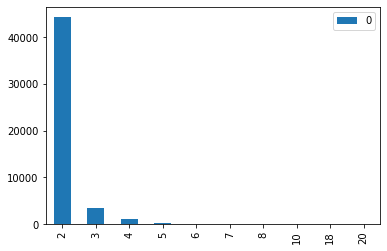

In [46]:
import numpy as np
import pandas as pd

values, counts = np.unique(clique_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

In [47]:
cliques = nx.find_cliques(largest_component_graph)
relevant_cliques = [clique for clique in cliques if len(clique) >=15]
clique_nodes = set(n for clique in relevant_cliques for n in clique)
cliques_subgraph = G.subgraph(clique_nodes)

In [48]:
from helper_functions.helper_fun import to_nx_graph
from pyvis.network import Network

nt = Network('500px', '100%', notebook=True)
nt.from_nx(cliques_subgraph)
nt.set_edge_smooth("dynamic")
#nt.toggle_physics(False)
nt.force_atlas_2based(gravity = -55)
nt.show('./html_networks/cliques_network.html')

## Community Detection

In [15]:
!pip install pygraphviz

     |████████████████████████████████| 118 kB 2.5 MB/s eta 0:00:01
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp38-cp38-linux_x86_64.whl size=204103 sha256=64c82b2f57ee1bfe97c84dbf054a77f1897fcd54c9d6c8b8c190b85b46cf0b30
  Stored in directory: /root/.cache/pip/wheels/77/c6/8b/566e1c26d0f9d41093e28d8e1768f1412d54846e3296114feb
Successfully built pygraphviz


In [16]:
import community as community_louvain
import pygraphviz 
from networkx.drawing.nx_agraph import graphviz_layout
    
# compute the best partition
partition = community_louvain.best_partition(largest_component_graph)

In [17]:
max_k_w = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    max_k_w = max_k_w + [list_nodes]

In [18]:
node_mapping = {}
map_v = 0
for node in largest_component_graph.nodes():
    node_mapping[node] = map_v
    map_v += 1

In [19]:
community_num_group = len(max_k_w)
color_list_community = [[] for i in range(len(largest_component_graph.nodes()))]

In [20]:
for i in G.nodes():
    for j in range(community_num_group):
        if i in max_k_w[j]:
            color_list_community[node_mapping[i]] = j

In [ ]:
edges = largest_component_graph.edges()
Feature_color_sub = color_list_community
node_size = 70
network = largest_component_graph
pos = graphviz_layout(largest_component_graph)


fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(network, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group, with_labels=False)
nx.draw_networkx_edges(network, pos)
nx.draw_networkx_labels(network, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [146]:
dendo

[{5046970: 0,
  1498320: 0,
  1497822: 530,
  14948439: 0,
  22459300: 0,
  5046966: 0,
  23581357: 0,
  23654879: 0,
  23807140: 0,
  26106203: 0,
  1144409: 0,
  26582559: 0,
  27648652: 0,
  29488170: 0,
  42308821: 0,
  2638684: 48,
  11618702: 48,
  11618344: 56,
  11617864: 48,
  11618781: 48,
  11617913: 48,
  11618707: 48,
  11617912: 56,
  11618710: 56,
  11618793: 56,
  11618511: 48,
  11618531: 48,
  11618782: 48,
  11617942: 48,
  11617865: 48,
  11618887: 48,
  11617914: 48,
  11618708: 48,
  11618532: 56,
  11617885: 48,
  11617878: 210,
  11618626: 56,
  11617930: 48,
  11617863: 48,
  11618534: 56,
  11617941: 48,
  11617911: 48,
  11617884: 48,
  11618373: 48,
  14615288: 48,
  14829033: 48,
  16885946: 48,
  38775335: 48,
  38776843: 48,
  5248332: 48,
  2942960: 48,
  89154: 48,
  2041899: 48,
  6296338: 53,
  5176002: 48,
  5175262: 48,
  2946338: 56,
  2922833: 48,
  2625027: 48,
  5175185: 48,
  3147114: 48,
  5175248: 48,
  5181184: 48,
  14562: 48,
  4240702: 48

# Investigating Corporations

# Investigating Resources and Works

# Investigating predefined set of Physiologists

* Gustav Fritsch (DE-588)115568808
* Eduard Hitzig (DE-588)116917423
* Hermann Munk (DE-588)117185930
* Nathan Zuntz (DE-588)118896202
* Friedrich Goltz (DE-588)116764694
* Adolf Fick (DE-588)118800000
* Jacques Loeb (DE-588)119133628

In [ ]:
physiologists = ["(DE-588)115568808", "(DE-588)116917423", "(DE-588)117185930", "(DE-588)118896202", 
                 "(DE-588)116764694", "(DE-588)118800000", "(DE-588)119133628"]

# Bibliography

Scifo, E. (2020). Hands-On Graph Analytics with Neo4j: Perform graph processing and visualization techniques using connected data across your enterprise. Birmingham, England: Packt Publishing.

Oldham, S., Fulcher, B., Parkes, L., Arnatkevic̆iūtė, A., Suo, C., & Fornito, A. (2019). Consistency and differences between centrality measures across distinct classes of networks. PLOS ONE, 14(7), e0220061. https://doi.org/10.1371/journal.pone.0220061